### Diffusion Monte-Carlo. Double well & Hydrogen atom

Diffusion Monte-Carlo method is a useful tool for computing groundstate wavefunction and energy of quantum system. Here I would explain the basic idea and give few examples of its work.

__References:__

[1] ["Introduction to the diffusion Monte-Carlo method"](https://arxiv.org/abs/physics/9702023v1)_, Ioan Kosztin et al.

---

__Basic idea__

In short, consider a quantum system with hamiltonian $\hat{H}$ and bound states $\left| \psi_n \right>$ with energies $E_n$. Arbitrary state of such system can be written as a superposition of the basis states:


$$\left| \psi(t) \right>  = \sum_{n}c_n e^{-i E_n t/ \hbar} \left| \psi_n \right>$$

Suppose you want to find groundstate wavefunction and energy of such system. If we replace time with imaginary time $t \rightarrow - i\tau$, the state will evolve as:

$$\left| \psi(\tau) \right>  = \sum_{n}c_n e^{- E_n \tau/ \hbar} \left| \psi_n \right>$$

We see that all summands decay exponentially. Now if we make energy shift equal to the ground state energy $E_0$, arbitrary state would evolve as

$$\left| \psi(\tau) \right>  =c_0 \left| \psi_0 \right>  + \sum_{n \neq 0}c_n e^{- (E_n-E_0) \tau/ \hbar} \left| \psi_n \right>,$$

so as $\tau \rightarrow \infty$ 

$$\left| \psi(\tau) \right> \rightarrow c_0 \left| \psi_0 \right> .$$

If initial projection of state on the ground state is not zero, we will eventually receive ground state of our system. By running algorithm with different energy shifts $E$ we can find one that doesn't grow/decay exponentially, which would correspond to ground state energy $E_0$.


--- 
__How to simulate this?__

It can be shown that 

### Algorithm implementation

In [4]:
import numpy as np
from numpy import exp, sqrt
from numpy.random import normal, uniform, randint
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size" : 16, "font.family" : "serif"})

Some modifications are introduced to adjust $E$ and initial $E_0$ guess for better convergence.

In [5]:
def W(V, x, dt, Et):
    return exp(-(V(x)-Et)*dt)


def DMC(V, bins, 
        t=1000, 
        N=int(1e4),
        N0=int(1e3), 
        alpha=1, 
        warmup_iters=int(1e2), 
        max_ratio=10,
        update_step=10):
    """
    V(x) - potential energy function
    bins - coordinates at which wavefunction is sampled(assumed uniform step)
    W(V, x, dt, Et) - returns probability, 
        - V=V(x) - potential, 
        - x - coordinate
        - dt-timestep, 
        - Et - energy
    t - time of simulation(imaginary one)
    N - number of particles(pilgrims)
    """
    dx = bins[1] - bins[0]
    dt = t/N
    sigma = sqrt(dt)
    pos_curr = normal(loc=0.0, scale=4.0, size=N0)
    counts, bins = np.histogram(pos_curr, bins=bins)
    
    Et = np.mean(V(pos_curr))/2
    N_particles = []
    energies = []
    
    counter = 0
    #Warmup
    alpha_damp = alpha
    for _ in range(warmup_iters):
        N_start = pos_curr.shape[0]

        #position step
        pos_curr += sigma*normal(size=N_start)
        energies.append(Et)
        N_particles.append(N_start)
        
        #get number of copies of replicas
        m_float = W(V, pos_curr, dt, Et) + uniform(size=N_start)
        m = m_float.astype(int)
        m[m > 3] = 3
 
        #birth/death
        pos_curr = np.repeat(pos_curr, m)[:max_ratio*N0]
        N_end = pos_curr.shape[0]
        
        #adjust Et
        counter += 1
        if counter == update_step:
            counter = 0
            Et += alpha/dt*(1 - N_end/N_start)
        
        energies.append(Et)
        N_particles.append(N_end)
        alpha_damp -= alpha/(2*warmup_iters)
        
        
    #Measuring groundstate
    for _ in range(N):
        N_start = pos_curr.shape[0]

        #position step
        pos_curr += sigma*normal(size=N_start)
        energies.append(Et)
        N_particles.append(N_start)
        counts += np.histogram(pos_curr, bins=bins)[0]
        
        #get number of copies of replicas
        m = W(V, pos_curr, dt, Et) + uniform(size=N_start)
        m = m.astype(int)
        m[m > 3] = 3
 
        #birth/death
        pos_curr = np.repeat(pos_curr, m)[:max_ratio*N0]
        N_end = pos_curr.shape[0]
        
        #adjust Et
        counter += 1
        
        if counter == update_step:
            counter = 0
            Et += alpha_damp/dt*(1 - N_end/N_start)
        
        energies.append(Et)
        N_particles.append(N_end)
        alpha_damp *= np.exp(-1/N)
        
        
    return counts/np.sqrt(np.sum(counts**2 * dx)), N_particles, energies


#DMC version for visualization
def DMC_visual(V, bins, 
               t=1000, 
               N=int(1e4), 
               N0=int(1e3), 
               alpha=1, 
               warmup_iters=int(1e2), 
               max_ratio=10):
    dt = t/N
    dx = bins[1] - bins[0]
    sigma = sqrt(dt)
    pos_curr = uniform(low=-0.9, high=0.9, size=N0)
    counts, bins = np.histogram(pos_curr, bins=bins)
    
    Et = np.mean(V(pos_curr))
    N_particles = []
    energies = []
    positions = []
    M = []
    M_float = []
    
    for _ in range(warmup_iters):
        N_start = pos_curr.shape[0]

        #position step
        pos_curr += sigma*normal(size=N_start)
        positions.append(pos_curr)
        energies.append(Et)
        N_particles.append(N_start)
        
        #get number of copies of replicas
        m_float = W(V, pos_curr, dt, Et) + uniform(size=N_start)
        m_float = W(V, pos_curr, dt, Et) + uniform(size=N_start)
        m = m_float.astype(int)
        m[m > 3] = 3
        m[m < 0] = 0
        M.append(m)
        M_float.append(m_float)

 
        #birth/death
        pos_curr = np.repeat(pos_curr, m)[:max_ratio*N0]
        positions.append(pos_curr)
        N_end = pos_curr.shape[0]
        
        #adjust Et
        Et += alpha/dt*(1 - N_end/N_start)
        energies.append(Et)
        N_particles.append(N_end)
        
        
        
    for _ in range(N):
        N_start = pos_curr.shape[0]

        #position step
        pos_curr += sigma*normal(size=N_start)
        energies.append(Et)
        N_particles.append(N_start)
        counts += np.histogram(pos_curr, bins=bins)[0]
        
        #get number of copies of replicas
        m_float = W(V, pos_curr, dt, Et) + uniform(size=N_start)
        m = m_float.astype(int)
        m[m > 3] = 3
        m[m < 0] = 0
        M.append(m)
        M_float.append(m_float)
 
        #birth/death
        pos_curr = np.repeat(pos_curr, m)
        positions.append(pos_curr)
        N_end = pos_curr.shape[0]
        
        #adjust Et
        Et += alpha/dt*(1 - N_end/N_start)
        energies.append(Et)
        N_particles.append(N_end)
        
        
    return counts/np.sum(counts * dx), N_particles, energies, positions, M, M_float

Let's see how algorithm works in case of harmonic potential $V(x) = \frac{x^2}{2}$. 

Analytical groundstate wavefunction is known:

$$\psi_0(x) = \pi ^{-1/4}\exp\left({-x^2/2}\right), E_0 = 0.5$$

In [6]:
def V(x):
    return 0.5 * x**2

def psi0(x):
    return np.pi**(-1/4) * np.exp(-x**2/2)

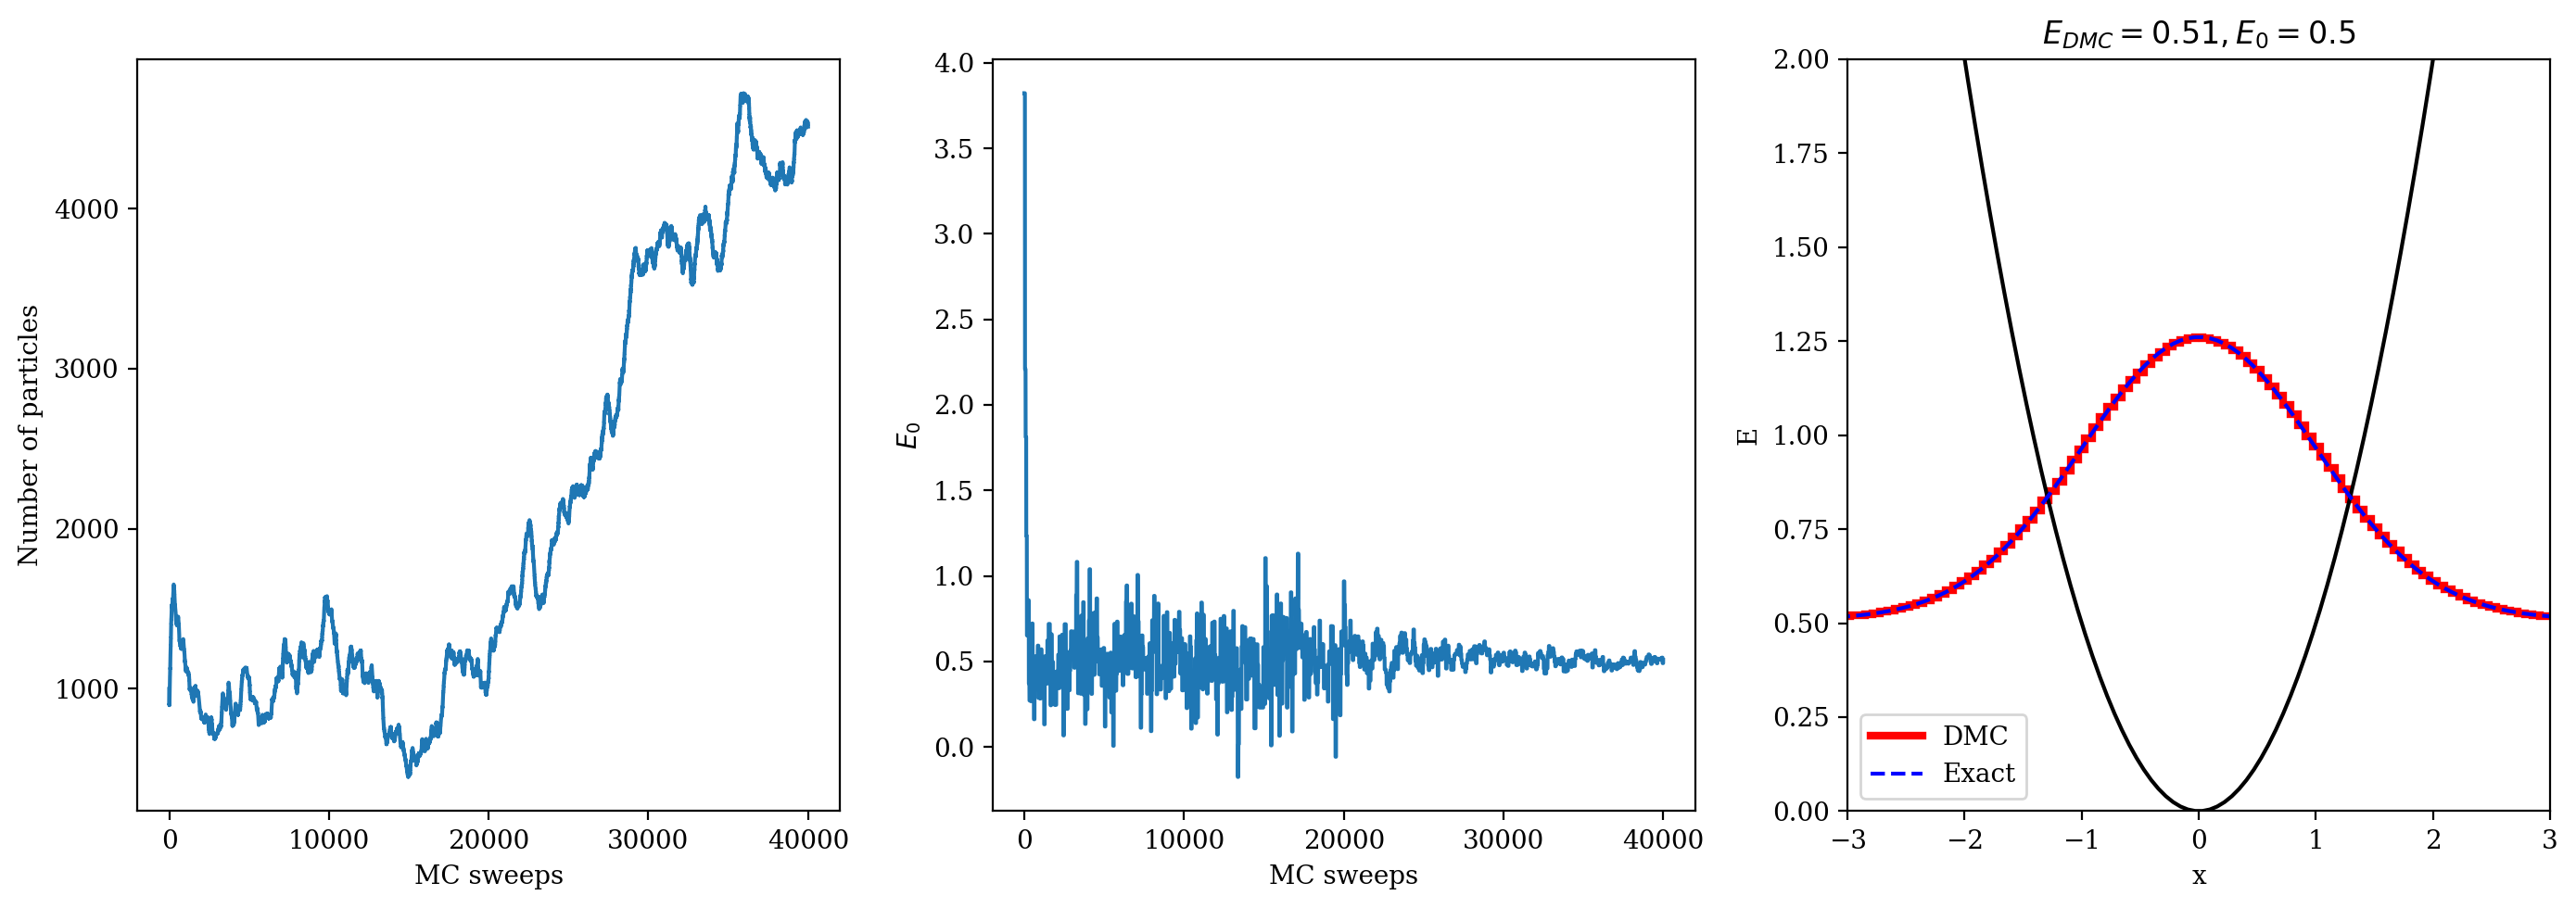

In [8]:
bins = np.linspace(-3.1, 3.1, 100)
warmup = int(1e4)
counts, Ns, energies = DMC(V, bins, t=100, 
                        N0=int(1e3), 
                        N=int(1e4), 
                        alpha=0.8,
                        warmup_iters=warmup,
                        update_step=20)

Egs = np.mean(energies[warmup:])


plt.figure(figsize=(14,5), dpi=200)
plt.subplot(131)
plt.plot(Ns)
plt.xticks(np.arange(0, int(5e4),int(1e4)))
plt.xlabel("MC sweeps")
plt.ylabel("Number of particles")

plt.subplot(132)
plt.plot(energies)
plt.xticks(np.arange(0, int(5e4),int(1e4)))
plt.xlabel("MC sweeps")
plt.ylabel("$E_0$")

plt.subplot(133)
plt.stairs(counts+Egs, 
           bins, 
           color='red', 
           label="DMC",
          linewidth=3)
plt.plot(bins, V(bins), color='black')
plt.plot(bins, Egs + psi0(bins), 
         color="blue", 
         linestyle="--", 
         label="Exact", 
         zorder=2)
plt.xlabel("x")
plt.ylabel("E")
plt.xlim(-3,3)
plt.ylim(0.0, 2.0)
plt.title("$E_{} = {}, E_0 = 0.5$".format("{DMC}", round(Egs, 3)))
plt.legend()

plt.tight_layout()
# plt.savefig("data/harmonic.pdf")

We received groundstate wavefunction and energy that match the exact solution! Further adjustments can be done to improve the convergence and precision, but I wouldn't stop on it.

### Double well. What's happening?

Let's visualize birth&death processes of pligrims in double well to make the things a bit more clear. 

In [13]:
def plot_graph(x, y, xmin, xmax):
    for i in range(len(x)-1):
        plt.scatter([x[i], x[i+1]], [y[i], y[i+1]],
                    edgecolors='black',
                    color="silver", 
                    s=50,
                    linewidth=1.0,
                    zorder=2)
        plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 
                 color='black', 
                 zorder=-2,
                linewidth=2)
        plt.xlim(xmin, xmax)
        plt.xticks([])
        plt.yticks([])
        
        
def DW(x):
    return 0.05*x**4 - 0.6*x**2

/var/folders/h9/ll8t8frd1r575llt96l1glhm0000gn/T/ipykernel_54489/1023240213.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


IndexError: list index out of range

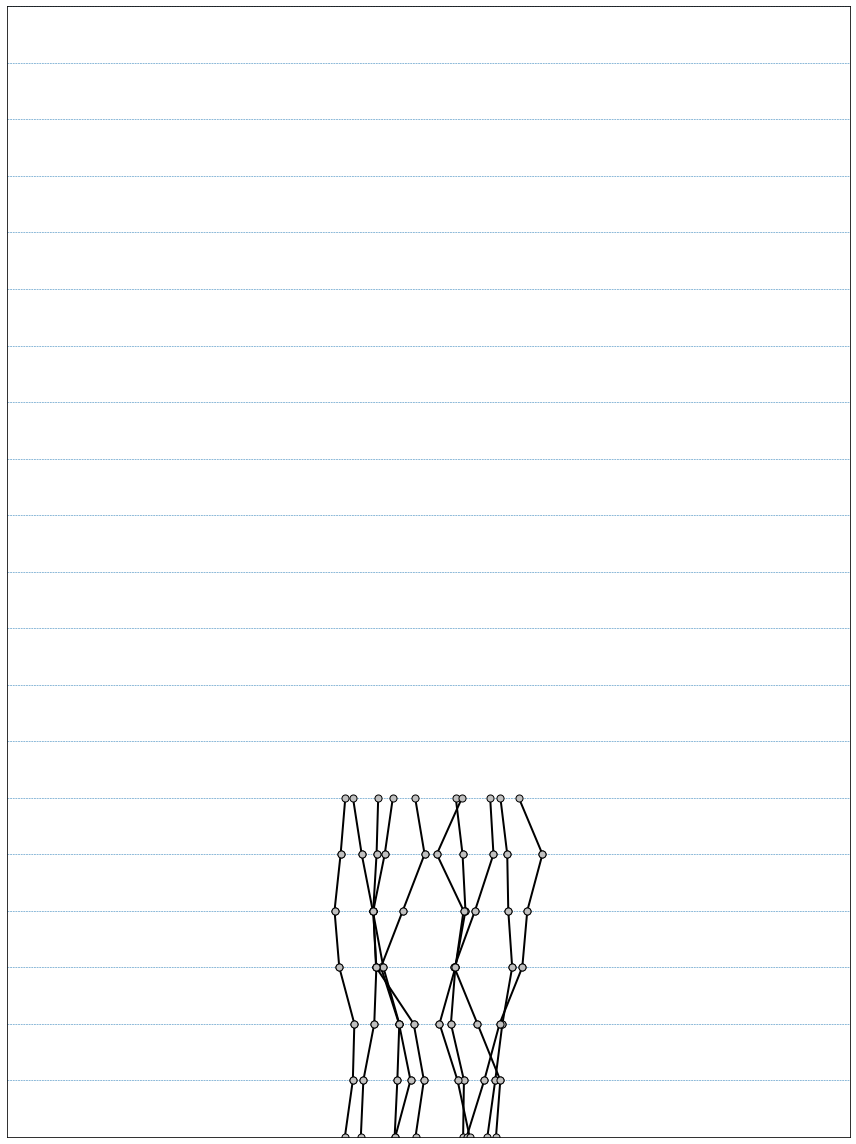

In [15]:
counts, Ns, energies, positions, M, M_float = DMC_visual(
    DW,
    bins,
    t=0.1, 
    N0=int(1e1), 
    N=int(1e1), 
    alpha=0.2,
    warmup_iters=int(2e0)
)

plt.figure(figsize=(12, 16))

for a in range(0, 21):
    plt.axhline(a, linestyle='--', linewidth=0.5, zorder=-3)
    
    
for n in range(0, 40, 2):
    pos0 = positions[n]
    pos1 = positions[n+2]
    
    ms = M[n//2]
    temp_count = 0
    
    for i in range(len(pos0)):
        pos_curr = pos0[i]
        if pos_curr >= xmin-bias and pos_curr <= xmax+bias:
            
            if ms[i] == 0:
                plt.scatter(pos_curr, lvl, color='red', zorder=4)
                
            if ms[i] > 1:
                plt.scatter(pos_curr, lvl, color='#00FF00', zorder=4)
                
            for j in range(ms[i]):
                pos_next = pos1[j + temp_count]
                
                if pos_next >= xmin-bias and pos_next <= xmax+bias:
                    plot_graph([pos_curr, pos_next], [lvl, lvl+1], xmin, xmax)

        temp_count += ms[i]
    lvl += 1
    
    plt.ylim(0, 20)
    plt.xticks()
    plt.tight_layout()

### Double-well potential groundstate

### Hydrogen atom groundstate